In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

hello there


In [9]:
def transform_resnet_block(nrOfFilters, inputLayer):
    init = keras.initializers.RandomNormal(stddev=0.02)
    resnet = keras.layers.Conv2D(nrOfFilters, (3,3), padding='same', kernel_initializer=init)(inputLayer)
    # instead of Batchnormalization
    resnet = InstanceNormalization(axis=-1)(resnet)
    resnet = keras.layers.Activation('relu')(resnet)
    # TODO reflection padding
    resnet = keras.layers.Conv2D(nrOfFilters, (3,3), padding='same', kernel_initializer=init)(resnet)
    resnet = InstanceNormalization(axis=-1)(resnet)
    resnet = keras.layers.Concatenate()([resnet, inputLayer])
    return resnet



In [10]:
# TODO generator model to use 6 ResNet layers as is used in the cycleGAN paper
def general_generator(imageShape=(256,256,3), nrOfResnet=9):
    init = keras.initializers.RandomNormal(stddev=0.02)
    inputImage = keras.Input(shape=imageShape)
    # ----Encode ------
    generator = keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(inputImage)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    # ----Transform -----
    for _ in range(nrOfResnet):
        generator = transform_resnet_block(256, generator)
    # ----Decode ------
    generator = keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    outputImage = keras.layers.Activation('tanh')(generator)

    model = keras.Model(inputImage, outputImage)
    return model



In [11]:
# test creation of a generator
imageShape = (256,256, 3)
model = general_generator(imageShape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
instance_normalization_28 (Inst (None, 256, 256, 64) 128         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 256, 256, 64) 0           instance_normalization_28[0][0]  
____________________________________________________________________________________________

In [12]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

def general_discriminator(imageShape):
    init = RandomNormal(stddev=0.02)
    inputImage = Input(shape=imageShape)

    discriminator = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputImage)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    output = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(discriminator)
    model = Model(inputImage, output)
    # TODO negative log likelihood (e.g. binary cross entropy).
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model


In [13]:
# test creation of a discriminator
imageShape = (256,256, 3)
model = general_discriminator(imageShape)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_52 (I (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 256)       5245

In [14]:
# Mean squared error, lambda 1
def adversarial_loss_model(generator, discriminator, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorOutput = generator(inputGenerator)
    outputDiscriminator = discriminator(generatorOutput)
    model = Model(inputGenerator, outputDiscriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mse', loss_weights=[1], optimizer=opt)
    return model

# If something already looks like from the target domain, you should not map it into a different image.
#Identity loss says that, if you fed image Y to generator G, it should yield the real image Y or something close to image Y.
# Mean absolute error, lambda 5
def identity_loss_model(generator, imageShape):
    inputIdentity = Input(shape=imageShape)
    outputIdentity = generator(inputIdentity)
    model = Model(inputIdentity, outputIdentity)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[5], optimizer=opt)
    return model

# Mean absolute error, lambda 10
def forward_cycle_loss_model(generatorG, generatorF, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorG_output = generatorG(inputGenerator)
    generatorF_output = generatorF(generatorG_output)
    model = Model(inputGenerator, generatorF_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[10], optimizer=opt)
    return model

# Mean absolute error, lambda 10
def backward_cycle_loss_model(generatorG, generatorF, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorF_output = generatorF(inputGenerator)
    generatorG_output = generatorG(generatorF_output)
    model = Model(inputGenerator, generatorG_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[10], optimizer=opt)
    return model


In [15]:
# test code creaton of models---
imageShape = (256,256, 3)
# generator G(x) -> y'
Gx_2_y = general_generator(imageShape)
# generator F(y') -> x'
Fy_2_x = general_generator(imageShape)
# discriminator D(y') -> real/fake painting?
Dy = general_discriminator(imageShape)
# discriminator D(x') -> real/fake landscape?
Dx = general_discriminator(imageShape)

adversarial_loss_model_G = adversarial_loss_model(Gx_2_y, Dy, imageShape)
identity_loss_model_G = identity_loss_model(Gx_2_y, imageShape)
forward_cycle_loss_model_G = forward_cycle_loss_model(Gx_2_y, Fy_2_x, imageShape)
backward_cycle_loss_model_G = backward_cycle_loss_model(Gx_2_y, Fy_2_x, imageShape)

adversarial_loss_model_F = adversarial_loss_model(Fy_2_x, Dx, imageShape)
identity_loss_model_F = identity_loss_model(Fy_2_x, imageShape)
forward_cycle_loss_model_F = forward_cycle_loss_model(Fy_2_x, Gx_2_y, imageShape)
backward_cycle_loss_model_F = backward_cycle_loss_model(Fy_2_x, Gx_2_y, imageShape)

print("disc a shape: ", Dy.output_shape)
adversarial_loss_model_G.summary()

disc a shape:  (None, 16, 16, 1)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model_4 (Functional)         (None, 256, 256, 3)       35276553  
_________________________________________________________________
model_6 (Functional)         (None, 16, 16, 1)         6962369   
Total params: 42,238,922
Trainable params: 42,238,922
Non-trainable params: 0
_________________________________________________________________


test image shpae:  (337, 450, 3)


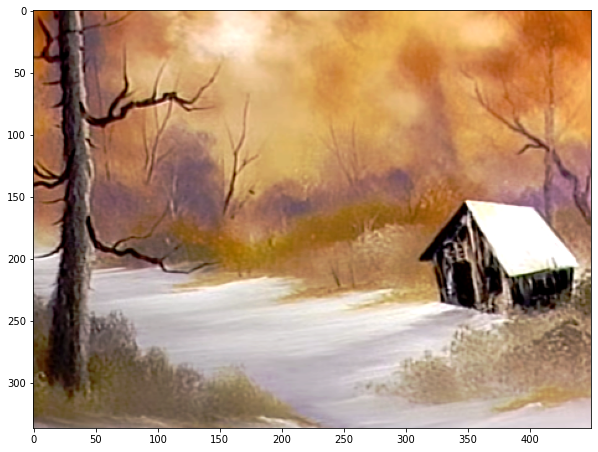

In [42]:
# sneak peak of a bob ross painting
from matplotlib import pyplot as plt
test_image = cv.imread('./data/bobross_paintings/Y/painting5.png')
print("test image shpae: ", test_image.shape)
test_image_bgr = cv.cvtColor(test_image, cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(test_image_bgr)
plt.show()

In [17]:
tfds_cache_dir = os.path.join(os.getcwd(),'tfds_cache')
os.makedirs(tfds_cache_dir, exist_ok = True)

# Note: The Keras home directory is hard-coded to
# "~/.keras" (Linux) or "%USERPROFILE%\.keras" on Windows
# so any model weights downloaded from "keras.applications"
# will be found there (in the sub-directory "models").
home_dir = os.path.expanduser("~")
keras_dir = os.path.join(home_dir,'.keras')
if os.path.isdir(keras_dir):
    print(os.listdir(keras_dir))

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')

batch_size = 2
img_height = 256
img_width = 256
data_dir_bob = './data/bobross_paintings'

train_ds_bob = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_bob,
  validation_split=0.025,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds_bob = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_bob,
  validation_split=0.025,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


['keras.json', 'models']
No GPU found
Found 403 files belonging to 1 classes.
Using 393 files for training.
Found 403 files belonging to 1 classes.
Using 10 files for validation.


In [18]:
batch_size = 2
img_height = 256
img_width = 256
data_dir_landscapes = './data/landscape_pictures'

train_ds_landscapes = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_landscapes,
  validation_split=0.025,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds_landscapes = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_landscapes,
  validation_split=0.025,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_bob = train_ds_bob.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds_landscapes = train_ds_landscapes.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# make the datasets iterable
paintings_batches = iter(train_ds_bob)
landscapes_batches = iter(train_ds_landscapes)
'''
first_image_batch, labels_batch = next(landscapes_batches)
first_image = first_image_batch[0]
print(first_image)
'''

Found 4319 files belonging to 1 classes.
Using 4212 files for training.
Found 4319 files belonging to 1 classes.
Using 107 files for validation.


'\nfirst_image_batch, labels_batch = next(landscapes_batches)\nfirst_image = first_image_batch[0]\nprint(first_image)\n'

In [35]:
'''All real images should be labelled 1's '''
#nextBatchRealPaintings, labelsBatchPaintings = next(paintings_batches)
#nextBatchRealLandscapes, labelsBatchLandscapes = next(landscapes_batches)
#print("painting 0: ", nextBatchRealPaintings[0])
# paintings label are 0
# print( "labels" ,labelsBatchPaintings)
#print("landscapes: ", nextBatchRealLandscapes[0], labelsBatchLandscapes[0])
# landscape labels are 0 too
#print("landscape labels ", labelsBatchLandscapes)

# TODO not optimal?
def make_labels_ones(tensorarray):
    tensor_array_of_ones = tf.ones((tf.size(tensorarray), 16, 16, 1), tf.int32)
    return tensor_array_of_ones 
#print(make_labels_ones(labelsBatchLandscapes))


In [20]:
# Imagepool based on: https://github.com/junyanz/CycleGAN/blob/master/util/image_pool.lua
# The paper defines an image pool of 50 generated images
def update_image_pool(pool, generatedImages, max_size=50):
	selected = list()
	for image in generatedImages:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [34]:
# -----test -------------
imageShape = (256,256, 3)
# generator G(x) -> y'
Gx2y = general_generator(imageShape)
# generator F(y') -> x'
Fy2x = general_generator(imageShape)
# discriminator D(y') -> real/fake painting?
Dy = general_discriminator(imageShape)
# discriminator D(x') -> real/fake landscape?
Dx = general_discriminator(imageShape)

batch_size = 2
# Pass real images thorugh both generators & create labels as 0 representing generated images
nextBatchRealLandscapes, labelsBatchLandscapes = next(landscapes_batches)
print("shape of image batch", nextBatchRealLandscapes.shape)
yPrimeArr = Gx2y.predict(nextBatchRealLandscapes)
print("shape of yprime prediction: ", yPrimeArr.shape)
yPrimeLabels = tf.zeros((batch_size, 256,256,1), tf.int32)
print("shape of yprime labels:: ", yPrimeLabels.shape)
print("yprime labels: Should be 0's: ", yPrimeLabels)

#y = ones((n_samples, patch_shape, patch_shape, 1))

shape of image batch (2, 256, 256, 3)
shape of yprime prediction:  (2, 256, 256, 3)
shape of yprime labels::  (2, 256, 256, 1)
yprime labels: Should be 0's:  tf.Tensor(
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]], shape=(2, 256, 256, 1), dtype=int32)


In [40]:
def train(Gx2y, Fy2x, Dy, Dx):
    batch_size = 2
    poolG, poolF = list(), list()
    # calculate the number of batches per training epoch
    #batchPerEpoch= int(len(trainX) / batchSize)
    # calculate the number of training iterations
    # TODO what if size trainX >> trainY??
    #steps = batchPerEpoch * epochs
    # loss models:
    adversarial_loss_model_G = adversarial_loss_model(Gx2y, Dy, imageShape)
    identity_loss_model_G = identity_loss_model(Gx2y, imageShape)
    forward_cycle_loss_model_G = forward_cycle_loss_model(Gx2y, Fy2x, imageShape)
    backward_cycle_loss_model_G = backward_cycle_loss_model(Gx2y, Fy2x, imageShape)

    adversarial_loss_model_F = adversarial_loss_model(Fy2x, Dx, imageShape)
    identity_loss_model_F = identity_loss_model(Fy2x, imageShape)
    forward_cycle_loss_model_F = forward_cycle_loss_model(Fy2x, Gx2y, imageShape)
    backward_cycle_loss_model_F = backward_cycle_loss_model(Fy2x, Gx2y, imageShape)

    # range(steps)
    # loop through all batches, then go on to the next epoch
    for i in range(1):
        # Gather batch, 16 st images
        nextBatchRealPaintings, labelsBatchPaintings = next(paintings_batches)
        nextBatchRealLandscapes, labelsBatchLandscapes = next(landscapes_batches)
        # Make the real images have label 1
        labelsBatchPaintings = make_labels_ones(labelsBatchPaintings)
        labelsBatchLandscapes = make_labels_ones(labelsBatchLandscapes)
        print("labels patch paintings shape:: ", labelsBatchPaintings.shape)
        # Pass real images thorugh both generators & create labels as 0 representing generated images
        yPrimeArr = Gx2y.predict(nextBatchRealLandscapes)
        yPrimeLabels = tf.zeros((batch_size, 16, 16, 1), tf.int32)
            #yPrimeArr = update_image_pool(poolG, yPrimeArr)
        xPrimeArr = Fy2x.predict(nextBatchRealPaintings)
        xPrimeLabels = tf.zeros((batch_size, 16, 16, 1), tf.int32)
            #xPrimeArr = update_image_pool(poolF, xPrimeArr)
        # Pass generated images trough both geenrators
        yPrimeCycled = Gx2y.predict(xPrimeArr)
        xPrimeCycled = Fy2x.predict(yPrimeArr)
        # identity check
        yThroughF = Fy2x.predict(nextBatchRealPaintings)
        xThroughG = Gx2y.predict(nextBatchRealLandscapes)
        # Pass generated images in corresponding discriminator
        DyReal = Dy.predict(nextBatchRealPaintings)
        DxReal = Dx.predict(nextBatchRealLandscapes)
        DyFake = Dy.predict(yPrimeArr)
        DxFake = Dx.predict(xPrimeArr)
        # Adversarial losses 
        G_loss_adv = adversarial_loss_model_G.train_on_batch(nextBatchRealLandscapes, labelsBatchPaintings)
        F_loss_adv = adversarial_loss_model_F.train_on_batch(nextBatchRealPaintings, labelsBatchLandscapes)
        # Cycle losses
        G_loss_cycle = forward_cycle_loss_model_G.train_on_batch(nextBatchRealLandscapes, nextBatchRealLandscapes)
        F_loss_cycle = forward_cycle_loss_model_F.train_on_batch(nextBatchRealPaintings, nextBatchRealPaintings)
        # TODO add backwards cycle losses
        # Identity losses
        G_loss_id = identity_loss_model_G.train_on_batch(nextBatchRealPaintings, nextBatchRealLandscapes)
        F_loss_id = identity_loss_model_F.train_on_batch(nextBatchRealLandscapes, nextBatchRealPaintings)
        # Discriminator losses
        Dy_loss_real = Dy.train_on_batch(nextBatchRealLandscapes, labelsBatchLandscapes)
        Dy_loss_fake = Dy.train_on_batch(yPrimeArr, yPrimeLabels)
        Dx_loss_real = Dx.train_on_batch(nextBatchRealPaintings, labelsBatchPaintings)
        Dx_loss_fake = Dx.train_on_batch(xPrimeArr, xPrimeLabels)

In [41]:
# -----test -------------
imageShape = (256,256, 3)
# generator G(x) -> y'
Gx2y = general_generator(imageShape)
# generator F(y') -> x'
Fy2x = general_generator(imageShape)
# discriminator D(y') -> real/fake painting?
Dy = general_discriminator(imageShape)
# discriminator D(x') -> real/fake landscape?
Dx = general_discriminator(imageShape)

train(Gx2y, Fy2x, Dy, Dx)
# -----end test -------

labels patch paintings shape::  (2, 16, 16, 1)


In [83]:
# TODO save models while training...
# TODO show status while training with callback

shape of new_img:  (256, 256, 3)


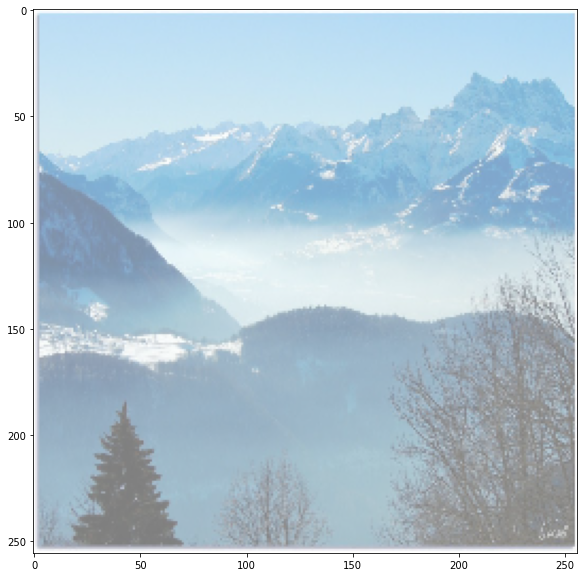

In [84]:
# Real image
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255.
new_img = (new_img + 1) / 2.0
print("shape of new_img: ", new_img.shape)
new_img_bgr = cv.cvtColor(new_img, cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(new_img_bgr)
plt.show()

shape of new_img:  (256, 256, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


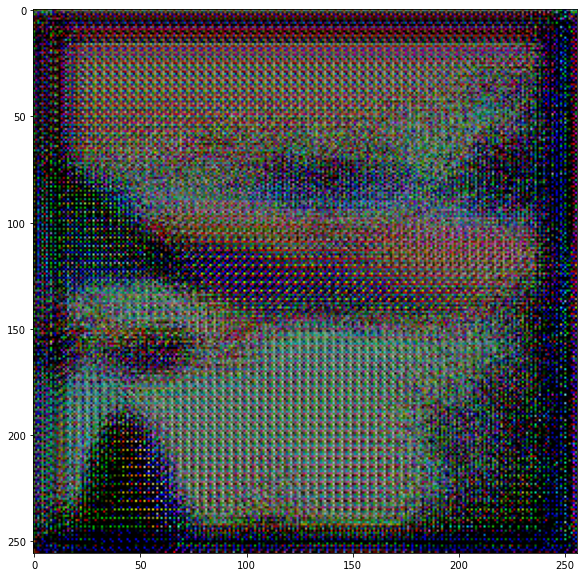

In [82]:
# Generated image with 1 epoch on 1 batch with 2 pictures
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255.
new_img = (new_img + 1) / 2.0
print("shape of new_img: ", new_img.shape)
new_img = new_img.reshape((1, 256, 256, 3))
generated_test_image = Gx2y.predict(new_img)
new_img_bgr = cv.cvtColor(generated_test_image.reshape((256,256,3)), cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(new_img_bgr)
plt.show()